[PDF-версия](./РК-1%20ИУ5-12М%20Кириллов%20Д.С..pdf)

![Титульный лист](./titulnik-rk-1.png)

# РК-1 ММО в АСОИУ (Методы машинного обучения в АСОИУ)

## ИУ5-22М Кириллов Д.С. Вариант 7

26.03.2024

## Задание

Для студентов группы ИУ5-22М номер варианта = номер в списке группы

| Номер варианта | Номер задачи №1 | Номер задачи №2 |
| -------------- | --------------- | --------------- |
| 7              | 7               | 27              |

### Задача №7

Для набора данных проведите устранение пропусков для одного (произвольного) числового признака с использованием метода заполнения медианой.


### Задача №27

Для набора данных для одного (произвольного) числового признака проведите обнаружение и замену (найденными верхними и нижними границами) выбросов на основе 5% и 95% квантилей.


### Дополнительные требования по группам:
Для студентов групп ИУ5-22М, ИУ5И-22М - для произвольной колонки данных построить гистограмму.

## Ход работы

### Подготовка датасета

Взял датасет **Demographic and Socio-economic Indicators - last update: September 2023** https://uis.unesco.org/bdds

В нем собраны различные социально-демографические и экономические метрики с разных стран по годам.

- INDICATOR_ID - код социально-демографической или экономической метрики. Категориальный признак.
- COUNTRY_ID - код государства. Категориальный признак.
- YEAR - год. Категориальный признак.
- VALUE	- значение этой социально-демографической или экономической метрики. Числовой признак.
- MAGNITUDE - пустая колонка
- QUALIFIER - пустая колонка

За некоторые года некоторые метрики могут быть пропущены. Это связано с тем, что расчеты по некоторым показателям не могли быть проведены из-за отсутствия данных. Либо эти данных никто не собирал, как в некоторых странах стретьего мира, либо эти страны имеют закрытую экономику, как Иран и КНДР. Однако, это нельзя считать полноценными пропусками. Если за такой-то год данные по такой-то метрике не были собраны, строка с такой страной, годом и метрикой просто будет отсутствовать. 

Также существует проблема, что данные о стране А собираются с 1900 года, а о стране Б - с 2000.

Для полноценного анализа, **исходный датасет нужно разбить** на более мелкие датасеты либо по исследуемой социально-демографической или экономической метрике, либо по стране.

В работе **буду искусственно внедрять пропуски**. Это проще, чем учитывать, что в такой-то из 241 стран в такой-то год произошли такие-то события, и потому данные за этот год можно считать пропуском.

In [33]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
import scipy.stats as stats
import math

%matplotlib inline

In [34]:
data_folder = '../data/'
countries_labels = pd.read_csv(data_folder + 'DEM_COUNTRY.csv')
indicator_labels = pd.read_csv(data_folder + 'DEM_LABEL.csv')
data_raw = pd.read_csv(data_folder + 'DEM_DATA_NATIONAL.csv')

In [35]:
data_raw

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER
0,200101,ABW,1970,5.924000e+01,NaN,NaN
1,200101,ABW,1971,5.897300e+01,NaN,NaN
2,200101,ABW,1972,5.866000e+01,NaN,NaN
3,200101,ABW,1973,5.905100e+01,NaN,NaN
4,200101,ABW,1974,5.968000e+01,NaN,NaN
...,...,...,...,...,...,...
303304,XTGOV.IMF,ZWE,2019,2.484000e+10,NaN,NaN
303305,XTGOV.IMF,ZWE,2020,1.726850e+11,NaN,NaN
303306,XTGOV.IMF,ZWE,2021,5.583440e+11,NaN,NaN
303307,XTGOV.IMF,ZWE,2022,2.329145e+12,NaN,NaN


Есть строки с большим количеством NaN. Узнаем, есть ли среди них полезные.

In [36]:
data_raw[~data_raw['MAGNITUDE'].isna()]

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER


In [37]:
data_raw[~data_raw['QUALIFIER'].isna()]

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER


Полезных нет. Эти 2 колонки можно удалить

In [38]:
df = data_raw.dropna(axis='columns', how='all')
df

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE
0,200101,ABW,1970,5.924000e+01
1,200101,ABW,1971,5.897300e+01
2,200101,ABW,1972,5.866000e+01
3,200101,ABW,1973,5.905100e+01
4,200101,ABW,1974,5.968000e+01
...,...,...,...,...
303304,XTGOV.IMF,ZWE,2019,2.484000e+10
303305,XTGOV.IMF,ZWE,2020,1.726850e+11
303306,XTGOV.IMF,ZWE,2021,5.583440e+11
303307,XTGOV.IMF,ZWE,2022,2.329145e+12


In [39]:
def two_lists_to_dict(keys, values):
  res = {}
  for key in keys:
      for value in values:
          res[key] = value
          values.remove(value)
          break
  return res

countries_labels = countries_labels.to_dict('list')
countries_labels = two_lists_to_dict(countries_labels['COUNTRY_ID'], countries_labels['COUNTRY_NAME_EN'])

indicator_labels = indicator_labels.to_dict('list')
indicator_labels = two_lists_to_dict(indicator_labels['INDICATOR_ID'], indicator_labels['INDICATOR_LABEL_EN'])


In [40]:
print(f'Число стран: {len(countries_labels)} | Число показателей: {len(indicator_labels)}')

Число стран: 241 | Число показателей: 35


In [41]:
indicator_labels

{'200101': 'Total population (thousands)',
 '200144': 'Population aged 15-24 years (thousands)',
 '200151': 'Population aged 65 years or older (thousands)',
 '200343': 'Population aged 14 years or younger (thousands)',
 '200345': 'Population aged 25-64 years (thousands) ',
 'DT.TDS.DECT.GN.ZS': 'Total debt service (% of GNI)',
 'NY.GDP.DEFL.ZS': 'GDP deflator (base year varies by country)',
 'NY.GDP.MKTP.CD': 'GDP (current US$)',
 'NY.GDP.MKTP.CN': 'GDP (current LCU)',
 'NY.GDP.MKTP.KD  ': 'GDP at market prices (constant 2010 US$)',
 'NY.GDP.MKTP.KD.ZG': 'GDP growth (annual %)',
 'NY.GDP.MKTP.KN': 'GDP (constant LCU)',
 'NY.GDP.MKTP.PP.CD': 'GDP, PPP (current international $)',
 'NY.GDP.MKTP.PP.KD': 'GDP, PPP (constant 2011 international $)',
 'NY.GDP.PCAP.CD': 'GDP per capita (current US$)',
 'NY.GDP.PCAP.CN': 'GDP per capita (current LCU)',
 'NY.GDP.PCAP.PP.CD': 'GDP per capita, PPP (current international $)',
 'NY.GDP.PCAP.PP.KD': 'GDP per capita, PPP (constant 2011 international $)

Т.к. у меня как бы 35 датасетов в одном, и 1 числовой признак Value, то значения Value не отмасштабированы. Это значит, что массив всех значений Value априори не подчиняется какому-то статистическому закону. Проводить восстановление значений будет бессмысленно.

Кроме того, такие абсолютные значения как годовой ВВП у стран могут отличаться на порядки, например, у КНР и Анголы. Для работы **нужно выбрать такие числовые метрики, которые не имели бы такой большой разброс**, например, **ожидаемая средняя продолжительность жизни человека**, или тот же **ВВП**, но **в процентах к предыдущему году**.

**Еще для второго задания мне нужно найти распределение, похожее на нормальное.** Подойдет метрика "ожидаемая средняя продолжительность жизни человека".

In [42]:
values_trash = df[df['INDICATOR_ID'] == "NY.GDP.MKTP.CN"]['VALUE']
values_trash.name = 'ВВП, $'

df1 = df[df['INDICATOR_ID'] == "SP.DYN.LE00.IN"]
df1.index = range(0, df1.shape[0])
df2 = df[df['INDICATOR_ID'] =="NY.GDP.MKTP.KD.ZG"]
df2.index = range(0, df2.shape[0])

values1 = df1['VALUE']
values1.name = 'Продолжительность жизни, лет'
values2 = df2['VALUE']
values2.name = 'Прирост ВВП за год, %'

<AxesSubplot:xlabel='Прирост ВВП за год, %', ylabel='Density'>

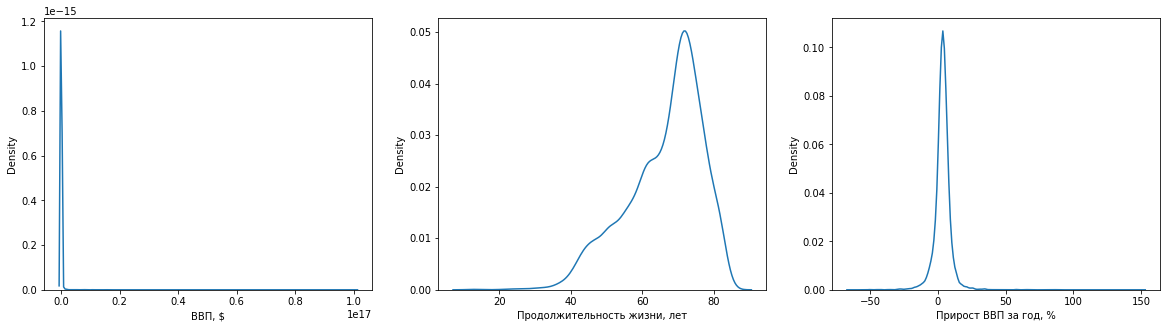

In [43]:
figure, axes = plt.subplots(1, 3, figsize=(20,5))

sns.kdeplot(ax=axes[0], data=values_trash)
sns.kdeplot(ax=axes[1], data=values1)
sns.kdeplot(ax=axes[2], data=values2)

Как видно, в "первом датасете" значения "VALUE" несопоставимы. Его рассматривать не буду.

Далее, в качестве первого датасета возьму значения "VALUE", когда "INDICATOR_ID" =="NY.GDP.MKTP.KD.ZG", а в качестве второго датасета - когда "INDICATOR_ID" =="SP.DYN.LE00.IN"


### Дополнительное требование 

<AxesSubplot:xlabel='Прирост ВВП за год, %', ylabel='Count'>

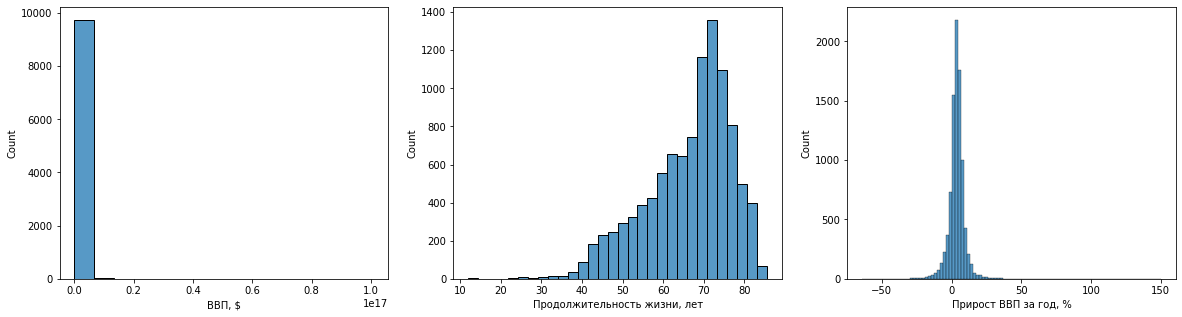

In [61]:
figure, axes = plt.subplots(1, 3, figsize=(20,5))

sns.histplot(ax=axes[0], data=values_trash, bins=15)
sns.histplot(ax=axes[1], data=values1, bins=30)
sns.histplot(ax=axes[2], data=values2, bins=100)

### Задача №7

Модифицирую первый датасет так, чтобы в колонке VALUE у меня было не более 5% пропусков.

In [45]:
print(df1.shape)

(10792, 4)


In [46]:
np.random.seed(1999)

n_rows = df1.shape[0]
nan_indeces = np.random.uniform(0, n_rows - 1, int(0.05 * n_rows))
nan_indeces = np.rint(nan_indeces).astype(int)
df1['VALUE'][nan_indeces] = np.NaN

# df.iloc[nan_indeces]['VALUE'] = np.NaN


C:\Users\dturc\AppData\Local\Temp\ipykernel_29608\145377067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['VALUE'][nan_indeces] = np.NaN
c:\Users\dturc\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:1135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(indexer, value)


In [47]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10792 entries, 0 to 10791
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   INDICATOR_ID  10792 non-null  object 
 1   COUNTRY_ID    10792 non-null  object 
 2   YEAR          10792 non-null  int64  
 3   VALUE         10261 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 337.4+ KB


Количество пропуском в поцентном соотношении:

In [48]:
(df1.isna().sum() / len(df1)).round(4) * 100

INDICATOR_ID    0.00
COUNTRY_ID      0.00
YEAR            0.00
VALUE           4.92
dtype: float64

In [49]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

<AxesSubplot:ylabel='Density'>

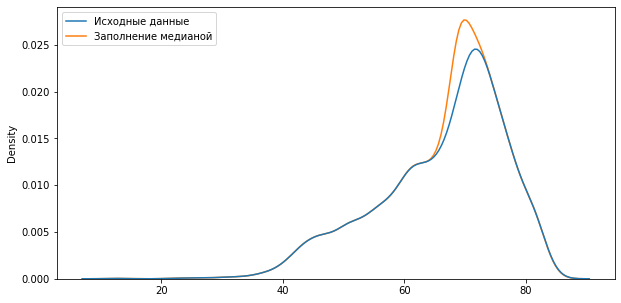

In [50]:
df1_imputed, df1_filled, df1_missed = impute_column(df1, 'VALUE', 'median')

fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(
  ax=ax,
  data=pd.DataFrame({
    'Исходные данные': df1['VALUE'].values,
    'Заполнение медианой': df1_imputed,
  }),
)

In [51]:
print('Было {} пропусков. Было заполнено {} пропусков значением {} (медиана)'.format(df1.isna().sum()['VALUE'], len(df1_filled), df1_filled[0]))


Было 531 пропусков. Было заполнено 531 пропусков значением 68.924 (медиана)


Заполнение пропусков медианой **выполнено**.

### Задача №27

In [52]:
print(df2.shape)

# Можно было бы наложить дополнительные выбросы

# n_rows = df2.shape[0]
# nan_indeces = np.random.uniform(0, n_rows - 1, int(0.10 * n_rows))
# nan_indeces = np.rint(nan_indeces).astype(int)
# df2['VALUE'][nan_indeces] = ...

(9152, 4)


In [53]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9152 entries, 0 to 9151
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   INDICATOR_ID  9152 non-null   object 
 1   COUNTRY_ID    9152 non-null   object 
 2   YEAR          9152 non-null   int64  
 3   VALUE         9152 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 286.1+ KB


Количество пропуском в поцентном соотношении:

In [54]:
(df2.isna().sum() / len(df2)).round(4) * 100

INDICATOR_ID    0.0
COUNTRY_ID      0.0
YEAR            0.0
VALUE           0.0
dtype: float64

In [55]:
# Графики из лекции
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # скрипичная диаграмма
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

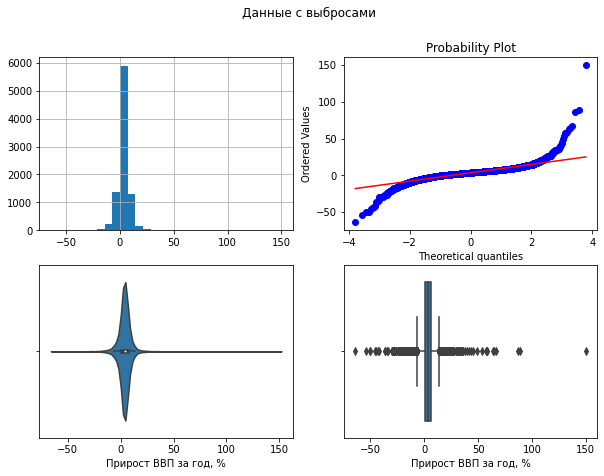

In [56]:
diagnostic_plots(df2, 'VALUE', 'Данные с выбросами')

In [57]:
lower_boundary = df2['VALUE'].quantile(0.05)
upper_boundary = df2['VALUE'].quantile(0.95)

In [58]:
df2_outlined = df2.copy()

df2_outlined['VALUE'] = np.where(
  df2_outlined['VALUE'] > upper_boundary, upper_boundary, np.where(
    df2_outlined['VALUE'] < lower_boundary, lower_boundary, df2_outlined['VALUE']
  )
)

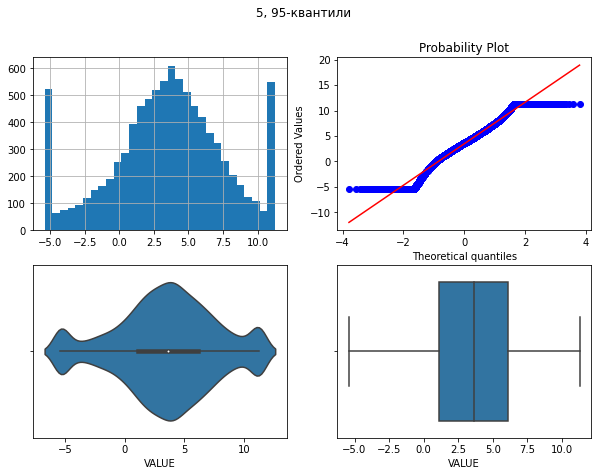

In [59]:
diagnostic_plots(df2_outlined, 'VALUE', '5, 95-квантили')

Обнаружение и замена выбросов на основе 5% и 95% квантилей **выполнены**.